# 仕様書作成のための検討用ノート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
# jupyter notebook の出力を省略させたくない場合のオプション設定
np.set_printoptions(threshold=8760)

In [3]:
def import_outside_air_temperature_d_t(area_number) -> np.ndarray:
    """
    外気温度を外部CSVファイルからND配列に読み込む
    Returns:
        outside_air_temperature_d_t : 外気温度[8760], ℃ 
    """
    df = pd.read_csv('climateData_' + str(area_number) + '.csv', encoding='SHIFT_JIS')
    ds = df['外気温[℃]']
    outside_air_temperature_d_t = ds.values
    return outside_air_temperature_d_t

In [4]:
# 日平均外気温度の読込テスト
import_outside_air_temperature_d_t(5)

array([ -0.9,  -2. ,  -2.8,  -4. ,  -4.2,  -4.6,  -4.7,  -2. ,   1.2,
         3.7,   5.1,   5.7,   6.3,   6.5,   6.2,   5. ,   3.6,   2.9,
         1.2,   1.1,  -0.7,  -1.5,  -2.4,  -3.3,  -3.5,  -4.1,  -5. ,
        -5.1,  -4.7,  -5.5,  -5.6,  -3.7,   0.3,   2.4,   3.8,   5.1,
         5.5,   5.5,   5.5,   5. ,   2.7,   1.4,   0.1,  -1.5,  -1.7,
        -1.8,  -1.8,  -1.9,  -3.2,  -4. ,  -3.4,  -5.1,  -4.8,  -4.6,
        -5.5,  -1.9,   0.7,   3.3,   4.6,   5.7,   6.1,   7. ,   6.9,
         6.5,   4.5,   3.8,   3.7,   3.6,  -0.6,  -1. ,  -1.7,  -2. ,
        -3.4,  -3.7,  -4.3,  -5.2,  -5.5,  -5.1,  -5.8,  -2.8,   1.7,
         3.5,   4.8,   5.2,   6.1,   6.5,   6.6,   5.9,   3.7,   1.1,
        -0.3,  -0.9,  -1.6,  -1.7,  -1.8,  -1.3,   0. ,   0.4,   0.3,
         0.1,  -0.4,  -0.1,  -1.3,  -0.7,   1. ,   4.3,   5.2,   6.2,
         6.4,   7.2,   8.2,   7. ,   4.1,   4.3,   4.9,   5.5,   5.9,
         5.7,   4.6,   4.5,   4.5,   4.6,   4.3,   4.9,   4.9,   4.6,
         4.7,   5. ,

In [5]:
def import_heating_season_d(area_number) -> np.ndarray:
    """
    暖冷房期間を外部CSVファイルからND配列に読み込む
    Returns:
         HeatingSeason_d: 暖房期間の判定[365], True/False
    """
    df = pd.read_csv('air_conditioning_season_sample.csv', encoding='SHIFT_JIS')
    ds = df[str(area_number) + '地域']
    HeatingSeason_d = ds.values
    return HeatingSeason_d

In [6]:
# 暖冷房期間の読込テスト
import_heating_season_d(5)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# (自立)換気設備
換気設備の運転方式別の評価を、比消費電力を通年の一定値から時刻別の変数に置き換えることで達成する事を基本とする。

### 時刻別比消費電力

時刻別比消費電力は運転方式毎に定める。選択しない場合でも通年で同じ値を持つ形にする。

各運転方式は排他的に選択されるものとする。

将来的には併用や季別の切り替えなどの需要も見込まれるかもしれない。
現状でも夏季：片側運転。冬期：温度差ハイブリッドなどの併用は少し手を入れれば可能と思われるが、実時住宅で行われているかは不明である。
そこまで、自動的に切り替える機能を有する換気システムは無いと思われる（そもそも、季節の切り替えを自動で行えるのか？）

$$
f_{ SFP, d, t }
=
\begin{cases}
f_{ SFP }
& ,
\mbox{制御しない}
\\
f_{ SFP, one-side, d, t }
& ,
\mbox{片側運転}
\\
f_{ SFP, by-pass, d, t }
& ,
\mbox{バイパス運転}
\\
f_{ SFP, hybrid-temperature, d, t }
& ,
\mbox{温度差利用型ハイブリッド運転}
\end{cases}
$$

$ f_{ SFP, d, t } $：日付dの時刻tにおける比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, one-side, d, t } $：日付dの時刻tにおける片側運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, by-pass, d, t } $：日付dの時刻tにおけるバイパス運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, hybrid-temperature, d, t } $：日付dの時刻tにおける温度差利用型ハイブリット運転機能を有する換気設備のの比消費電力,W/(m<sup>3</sup>/h)   

In [7]:
def hourly_sfp(
        ventilation_control_mode,
        sfp,
        sfp_bypass,
        area_number,
        mechanical_ventilation_volume,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_and_exhaust_air,
        house_story_number):
    
    """時刻別比消費電力量を計算する
    
    Parameters
    ----------
    ventilation_cntrol_mode : strings
        換気設備の制御方式（制御しない、片側運転、バイパス運転、温度差利用型ハイブリッド運転）,--  
        
    sfp : float
        比消費電力(省エネ基準プログラムで入力された値を参照する),W/(m^3/h)  

    sfp_bypass : float
        バイパス運転時の比消費電力,W/(m^3/h)  
          
    area_number : int
        地域区分番号,--
    
    mechanical_ventilation_volume : float
        機械換気量（省エネ基準プログラムの内部計算値）,m^3/h 
    
    room_temperature : float
        室温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_and_exhaust_air : float
        給排気端末の有効開口面積の合計値,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
        
    
    Returns
    ----------
    hourly_sfp_ : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列,W/(m^3/h)  
        d日t時の比消費電力量が年開始時から8760個連続して格納されている
    """
    # 日別暖房期間判定のインポート
    daily_heating_season = import_heating_season_d(area_number)
    
    if ventilation_control_mode == "制御しない":
        hourly_sfp_ = np.ones(8760) * sfp
        
    elif ventilation_control_mode == "片側運転":
        hourly_sfp_ = hourly_sfp_by_one_side_system(sfp, HeatingSeason_d)
    
    elif ventilation_control_mode == "バイパス運転":
        hourly_sfp_ = hourly_sfp_by_bypass_system(sfp, sfp_bypass, HeatingSeason_d)
    
    elif ventilation_control_mode == "温度差利用型ハイブリッド運転":
        
        # 時刻別外気温度のインポート
        hourly_outside_air_temperature = \
            import_outside_air_temperature_d_t(area_number)
        
        # 現時点では給排気口の面積は1:1とするため、給気口面積は全体の半分とする。
        opening_area_of_supply_air = opening_area_of_supply_and_exhaust_air \
                                     / 2
        opening_area_of_exhaust_air = opening_area_of_supply_and_exhaust_air \
                                      - opening_area_of_supply_air
        
        # 現時点では平屋は評価対象外、3階建て以上は未実装のためhouse_story_number は「2」の固定値となる。
        hourly_sfp_ = \
            hourly_sfp_by_hybrid_system_type_temperature(
                sfp,
                mechanical_ventilation_volume,
                hourly_outside_air_temperature,
                daily_heating_season,
                room_temperature,
                total_leakage_area_of_house_per_unit_area,
                total_floor_area,
                use_chimney,
                opening_area_of_supply_air,
                opening_area_of_exhaust_air,
                house_story_number)
    
    else:
        raise Exception
    
    return hourly_sfp_

## 片側運転機能を有する換気設備の比消費電力

### 時刻別比消費電力

単純に夏期・中間期において消費電力を減じる係数を掛けるだけ。

本質的には内外温度差での判定が望ましくはある。

$$
f_{ SFP, one-side, d, t }
=
f_{ SFP }
\times
C_{ one-side, d, t }
$$

$$
C_{ one-side, d, t }
=
\begin{cases}
0.58
& ,
HeatingSeason_{ d } = \mbox{False}
\\
1
& ,
HeatingSeason_{ d } = \mbox{True}
\end{cases}
$$

$ f_{ SFP, one-side, d, t } $：日付dの時刻tにおける片側運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：換気設備の比消費電力,W/(m<sup>3</sup>/h)    
$ C_{ single, d, t } $：日付dの時刻tにおける片側運転の比消費電力の補正係数,-  
$ HeatingSeason_{ d } $：日付dが暖房期である,True/False   

In [8]:
def hourly_sfp_by_one_side_system(fsp, daily_heating_season):
    """片側運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    sfp : float
        比消費電力(省エネ基準プログラムで入力された値を参照する),W/(m^3/h)  
        
    daily_heating_season : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    Returns
    ----------
    hourly_sfp_by_one_side_sys : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の比消費電力量が年開始時から8760個連続して格納されている
    """
    
    # 時刻別の補正係数を作成する
    hourly_heating_season = np.repeat(daily_heating_season, 24)
    hourly_C_one_side = np.where(hourly_heating_season == True, 1, 0.58)
    
    # 時刻別の比消費電力を作成する
    hourly_sfp_by_one_side_sys = fsp * hourly_C_one_side
    
    return hourly_sfp_by_one_side_sys

In [9]:
# 片側運転の動作テスト
hourly_sfp_by_one_side_system(0.3, np.tile([True, False, True, False, True], 73))

array([ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,  0.174,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
        0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
      

## バイパス運転を有する換気設備の比消費電力

### 時刻別比消費電力
$$
f_{ SFP, by-pass, d, t }
=
\begin{cases}
f_{ SFP }
& ,
HeatingSeason_{ d } = \mbox{True}
\\
f_{ SFP, by-pass }
& ,
HeatingSeason_{ d } = \mbox{False}
\end{cases}
$$

$ f_{ SFP, by-pass, d, t } $：日付dの時刻tにおけるバイパス運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：換気設備の比消費電力,W/(m<sup>3</sup>/h)    
$ f_{ SFP, by-pass } $：換気設備のバイパス運転時の比消費電力,W/(m<sup>3</sup>/h)    

In [10]:
def hourly_sfp_by_bypass_system(sfp, sfp_bypass, daily_heating_season):
    """バイパス運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    sfp : float
        比消費電力(省エネ基準プログラムで入力された値を参照する),W/(m^3/h)  
    
    sfp_bypass : float
        バイパス運転時の比消費電力,W/(m^3/h)  
        
    daily_heating_season : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    Returns
    ----------
    hourly_sfp_by_bypass_sys : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
    hourly_heating_season = np.repeat(daily_heating_season, 24)
    hourly_sfp_by_bypass_sys = np.where(hourly_heating_season == True, sfp, sfp_bypass)
    
    return hourly_sfp_by_bypass_sys

In [11]:
# バイパス運転の動作テスト
hourly_sfp_by_bypass_system(0.3, 0.5, np.tile([True, False, True, False, True], 73))

array([ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0

## 温度差利用型ハイブリッド運転を有する換気設備の比消費電力

### 時刻別比消費電力
$$
f_{ SFP, hybrid-temperature, d, t }
=
\begin{cases}
0
& ,
EnableHybrid_{ d, t } = \mbox{True}
\\
f_{ SFP }
& ,
EnableHybrid_{ d } = \mbox{False}
\end{cases}
$$

$ EnableHybrid_{ d, t } $：日付dの時刻tにおける温度差利用型ハイブリッド運転が有効であるか否かの判定,True/False

In [12]:
def hourly_sfp_by_hybrid_system_type_temperature(
        sfp,
        mechanical_ventilation_volume,
        hourly_outside_air_temperature,
        daily_heating_season,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number):

    """温度差利用ハイブリッド運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    sfp : float
        比消費電力,W/(m^3/h)  
    
    mechanical_ventilation_volume : float
        機械換気量（省エネ基準プログラムの内部計算値）,m^3/h 
        
    hourly_outside_air_temerature : ndarray(N-dimensional array)
        1年間の全時間の外気温度を格納したND配列, ℃
        d日t時の可否判定が年開始時から8760個連続して格納されている
        
    daily_heating_season : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, True/False
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階      
    
    
    Returns
    ----------
    hourly_sfp_by_hybrid_system_type_temp : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
    
    hourly_enable_hyb = \
        hourly_enable_hybrid(
            mechanical_ventilation_volume,
            hourly_outside_air_temperature,
            daily_heating_season,
            room_temperature,
            total_leakage_area_of_house_per_unit_area,
            total_floor_area,
            use_chimney,
            opening_area_of_supply_air,
            opening_area_of_exhaust_air,
            house_story_number)
                                                  
    
    hourly_sfp_by_hybrid_system_type_temp = \
        np.where(hourly_enable_hyb == True, 0, sfp)
    
    return hourly_sfp_by_hybrid_system_type_temp

In [13]:
def hourly_enable_hybrid(
        mechanical_ventilation_volume,
        hourly_outside_air_temperature,
        daily_heating_season,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number):

    """温度差利用ハイブリッド運転が有効になる時刻を判定する。
    
    Parameters
    ----------
    mechanical_ventilation_volume : float
        機械換気量（省エネ基準プログラムの内部計算値）,m^3/h 
        
    hourly_outside_air_temerature : ndarray(N-dimensional array)
        1年間の全時間の外気温度を格納したND配列, ℃
        d日t時の可否判定が年開始時から8760個連続して格納されている
        
    daily_heating_season : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, True/False
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階
        
        
    Returns
    ----------
    hourly_enable_hyb : ndarray(N-dimensional array)
        1年間の全時間の温度差利用型ハイブリッド運転の可否判定を格納したND配列, True/False
        d日t時の可否判定が年開始時から8760個連続して格納されている
    """
    
    hourly_natural_ventilation_vol = \
        hourly_natural_ventilation_volume(
            hourly_outside_air_temperature,
            daily_heating_season,
            room_temperature,
            total_leakage_area_of_house_per_unit_area,
            total_floor_area,
            use_chimney,
            opening_area_of_supply_air,
            opening_area_of_exhaust_air,
            house_story_number)            
    
    hourly_enable_hyb = \
        np.where(hourly_natural_ventilation_vol >= mechanical_ventilation_volume,
                 True,
                 False)
    
    return hourly_enable_hyb

In [14]:
def hourly_natural_ventilation_volume(
        hourly_outside_air_temperature,
        daily_heating_season,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number):

    """温度差利用時の時刻別自然換気量を計算する。
    
    Parameters
    ----------        
    hourly_outside_air_temerature : ndarray(N-dimensional array)
        1年間の全時間の外気温度を格納したND配列, ℃
        d日t時の可否判定が年開始時から8760個連続して格納されている
        
    daily_heating_season : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, True/False
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階
        
    Returns
    ----------
    hourly_natural_ventilation_vol : ndarray(N-dimensional array)
        1年間の自然換気量を格納したND列, m^3/h
        d日t時の自然換気量が年開始時から8760個連続して格納されている
        
    """
    
    hourly_heating_season = np.repeat(daily_heating_season, 24)
    
    hourly_natural_ventilation_vol = np.zeros(8760)
    
    for t in range(8760):
        
        if hourly_heating_season[t] == True:
            hourly_natural_ventilation_vol[t] = \
                natural_ventilation_volume(
                    room_temperature,
                    hourly_outside_air_temperature[t],
                    total_leakage_area_of_house_per_unit_area,
                    total_floor_area,
                    use_chimney,
                    opening_area_of_supply_air,
                    opening_area_of_exhaust_air,
                    house_story_number)
                                                
    return hourly_natural_ventilation_vol

In [15]:
def natural_ventilation_volume(
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number):

    """温度差利用時の自然換気量をscipyを利用して収束計算（二分法）で求める。
    
    Parameters
    ----------
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  

    
    Returns
    ----------
    natural_ventilation_vol : float
        自然換気量（ここでは流入風量）,m^3/h 
    
    """
    
    # 高階関数による引数と戻り値の単純化
    def make_high_order_function_of_air_flow(): 
    
        def new_air_flow(atmospheric_pressure_at_a_basic_height):
            
            air_flow_ballance, air_inflow, air_outflow = \
                air_flow(
                    atmospheric_pressure_at_a_basic_height,
                    room_temperature,
                    outside_air_temperature,
                    total_leakage_area_of_house_per_unit_area,
                    total_floor_area,
                    use_chimney,
                    opening_area_of_supply_air,
                    opening_area_of_exhaust_air,
                    house_story_number)
            
            return air_flow_ballance
        
        return new_air_flow
    
    f = make_high_order_function_of_air_flow()
    
    
    # scipyによる収束計算
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html
    # 戻り値の詳細は
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.RootResults.html#scipy.optimize.RootResults
    
    from scipy import optimize
    
    # scipy.optimize.bisect の引数 xtol, rtol の調査報告
    # xtol, rtol は numpy.allclose 用の引き数。
    # 収束判定を　numpy.allclose で行いたいときに使用するのではないか？
    # https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
    
    # 収束計算用定数(値は「収束用関数の連続性の確認(bisectの初期値の検討)」セルで検討・調整する)
    MINIMUM_VALUE = -1 * 10**3
    MAXIMUM_VALUE = 10**3
    MAXIMUM_ITERATION_COUNTS = 10**4
    
    # 本来、引数の指定もできるが高階関数で引数を絞っている
    # xtolとrtolは解説HPのデフォルト値をそのまま使用している。
    root = optimize.bisect(
                f,
                MINIMUM_VALUE,
                MAXIMUM_VALUE, 
                xtol=2e-12, 
                rtol=8.881784197001252e-16,
                maxiter=MAXIMUM_ITERATION_COUNTS,
                full_output=True,
                disp=True)
    
    # 戻り値は(root, iterations, function_calls, flag)：full_output=Trueの時
    #print (root)
    
    atmospheric_pressure_at_a_basic_height = root[0]
    
    # 得られる解は風量収支のため、流入・流出風量を再計算する　
    air_flow_ballance, air_inflow, air_outflow = \
        air_flow(
            atmospheric_pressure_at_a_basic_height,
            room_temperature,
            outside_air_temperature,
            total_leakage_area_of_house_per_unit_area,
            total_floor_area,
            use_chimney,
            opening_area_of_supply_air,
            opening_area_of_exhaust_air,
            house_story_number)
    
    # 仕様書における許容誤差の判定 「10^-2 m^3/hの範囲内」
    if air_flow_ballance * 100 > 1:
        raise Exception
    
    natural_ventilation_vol = air_inflow
        
    return natural_ventilation_vol

In [16]:
def air_flow(
        atmospheric_pressure_at_a_basic_height,
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number):

    """温度差利用時の自然換気量を求める(すきま風計算マクロ.xlsm を参考にしている)。
    
    Parameters
    ----------
    atmospheric_pressure_at_a_basic_height : float
        基点（ここでは1FL）の室内圧,Pa  
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  

    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    Returns
    ----------
    air_flow_ballance : float
        風量収支,m^3/h

    air_inflow : float
        流入風量（ここでは自然換気量）,m^3/h

    air_outflow : float
        流出風量,m^3/h
    
    """
    
    air_flow_ballance = 0
    air_inflow = 0
    air_outflow = 0
    
    # 平屋は現時点では評価対象外。空の関数のみ用意している状態。
    if house_story_number ==1:
        air_flow_ballance, air_inflow, air_outflow = \
            air_flow_in_1story_house(
                atmospheric_pressure_at_a_basic_height,
                room_temperature,
                outside_air_temperature,
                total_leakage_area_of_house_per_unit_area,
                total_floor_area,
                use_chimney,
                opening_area_of_supply_air,
                opening_area_of_exhaust_air)
            
    if house_story_number == 2:
        air_flow_ballance, air_inflow, air_outflow = \
            air_flow_in_2story_house(
                atmospheric_pressure_at_a_basic_height,
                room_temperature,
                outside_air_temperature,
                total_leakage_area_of_house_per_unit_area,
                total_floor_area,
                use_chimney,
                opening_area_of_supply_air,
                opening_area_of_exhaust_air)
        
    # 3階は現時点では未実装。空の関数のみ用意している状態。
    if house_story_number == 3:
        air_flow_ballance, air_inflow, air_outflow = \
            air_flow_in_3story_house(
                atmospheric_pressure_at_a_basic_height,
                room_temperature,
                outside_air_temperature,
                total_leakage_area_of_house_per_unit_area,
                total_floor_area,
                use_chimney,
                opening_area_of_supply_air,
                opening_area_of_exhaust_air)
        
    return air_flow_ballance, air_inflow, air_outflow

In [17]:
def air_flow_in_1story_house(
        atmospheric_pressure_at_a_basic_height,
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air):
    
    # 現時点では平屋は評価対象外のため、関数のみ用意しておく。実装時にはこちらに記述する事。
    
    air_flow_ballance = 0
    air_inflow = 0
    air_outflow = 0
    
    return air_ballance, air_inflow, air_outflow

In [18]:
def air_flow_in_2story_house(
        atmospheric_pressure_at_a_basic_height,
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air):
    
    """2階建ての温度差利用時の自然換気量を求める(すきま風計算マクロ.xlsm を参考にしている)。
    
    Parameters
    ----------
    atmospheric_pressure_at_a_basic_height : float
        基点（ここでは1FL）の室内圧,Pa  
    
    room_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    total_leakage_area_of_house_per_unit_area : float
        単位面積当たりの総相当隙間面積（いわゆるC値）,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    use_chimney : boolean
        煙突換気を使用する(true）／しない(false)  
    
    opening_area_of_supply_air : float
        給気端末の有効開口面積,m^2  
    
    oeping_area_of_exhaust_air : float
        排気端末の有効開口面積,m^2  
    
    
    Returns
    ----------
    air_flow_ballance : float
        風量収支,m^3/h

    air_inflow : float
        流入風量（ここでは自然換気量）,m^3/h

    air_outflow : float
        流出風量,m^3/h
    
    """
    
    # 相当隙間面積
    # 総相当隙間面積[cm^2]
    total_leakage_area = total_leakage_area_of_house_per_unit_area * total_floor_area
        
    # 総相当隙間面積[m^2]
    total_leakage_area = total_leakage_area * 10**-4

    # 住宅全体の隙間面積の分割数
    # 2階建てなので各階の床・天井を想定し「4」となる。
    # 階数が増えるごとに「2」加算される。
    div_num = 4
    
    # 相当隙間面積[m^2]
    # 1階床面
    leakage_area_at_1FL = total_leakage_area / div_num
    
    # 1階天井面
    leakage_area_at_1CL = total_leakage_area / div_num
    
    # 2階床面
    leakage_area_at_2FL = total_leakage_area / div_num
    
    # 2階天井面
    leakage_area_at_2CL = total_leakage_area / div_num
    
    # 相当開口面積のリスト化
    # 給排気端末は有効開口面積を想定している（使用している数式の縛り）
    # 流量係数を反映した、いわゆるαAであることに注意する事。
    # カタログなどに表記される有効開口面積は αAなのか正味のA（ガラリ・メッシュ等を除いた面積）なのか？
    # http://www.melcoairtec.co.jp/webcatalog/pdf/253_254.pdf
    area_list = [opening_area_of_supply_air,
                 opening_area_of_exhaust_air,
                 leakage_area_at_1FL,
                 leakage_area_at_1CL,
                 leakage_area_at_2FL,
                 leakage_area_at_2CL]
    
    
    # 端末と隙間の高さの定義
    # 1FLを基準とした相対高さ[m] 
    # 1階床面
    height_of_1FL = 0
    
    # 給気端末（通常は1階中央付近。煙突換気時は1階床下を想定）
    if use_chimney == True:
        height_of_SA = -0.25
    else:
        height_of_SA = 1.6
    
    # 1階天井面
    height_of_1CL = 2.4
    
    # 2階床面
    height_of_2FL = 2.9
    
    # 排気端末（通常は2階中央付近。煙突換気時は煙突上端を想定）
    if use_chimney == True:
        height_of_EA = 7.75
    else:
        height_of_EA = 4.5
    
    # 2階天井面
    height_of_2CL = 5.3

    
    # 空気密度
    # 乾燥空気密度[kg/m^3]
    the_density_of_dry_air_at_room_temperature = 353.25 / (room_temperature + 273.15)
    the_density_of_dry_air_at_outside_air_temperature = 353.25 / (outside_air_temperature + 273.15)
    
    # 乾燥室内基準の空気密度の差[kg/m^3]
    # 室内基準とする
    the_differential_density_of_dry_air = the_density_of_dry_air_at_outside_air_temperature \
                                          - the_density_of_dry_air_at_room_temperature    
    
    
    # 空気密度のリスト化(風量計算でmap関数を使用するので開口部と同じ大きさのリストが必要)
    the_density_of_dry_air_at_room_temperature_list = \
        [the_density_of_dry_air_at_room_temperature] * len(area_list)
    the_density_of_dry_air_at_outside_air_temperature_list = \
        [the_density_of_dry_air_at_outside_air_temperature] * len(area_list)
    
        
    # 差圧
    def differential_pressure_at_a_height(
            atmospheric_pressure_at_a_basic_height,
            height_of_calculation_point,
            the_density_of_dry_air_at_room_temperature,
            the_density_of_dry_air_at_outside_air_temperature):
        
        """任意高さの差圧を求める

        Parameters
        ----------
        atmospheric_pressure_at_a_basic_height : float
        基点（ここでは1FL）の室内圧,Pa  

        height_of_calculation_point : float
            計算対象の高さ,m
            
        the_density_of_dry_air_at_room_temperature : float
            室内空気の乾燥空気の密度,kg/m^3
            
        the_density_of_dry_air_at_outside_air_temperature : float
            外気の乾燥空気の密度,kg/m^3  


        Returns
        ----------
        differential_pressure : float
            計算対象高さの差圧,Pa

        """
        
        # すきま風マクロと検証するために重力加速度は9.8とする（仕様書とは異なるので注意）
        differential_pressure = 9.8 \
                                * (the_density_of_dry_air_at_room_temperature \
                                   - the_density_of_dry_air_at_outside_air_temperature) \
                                * height_of_calculation_point \
                                - atmospheric_pressure_at_a_basic_height

        return differential_pressure
    
    
    # 1階床面
    differential_pressure_at_1FL = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_1FL,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    
    # 1階天井面
    differential_pressure_at_1CL = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_1CL,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    
    # 2階床面
    differential_pressure_at_2FL = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_2FL,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    
    # 2階天井面
    differential_pressure_at_2CL = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_2CL,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    # 給気端末
    differential_pressure_at_SA = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_SA,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    # 排気端末
    differential_pressure_at_EA = \
        differential_pressure_at_a_height(atmospheric_pressure_at_a_basic_height,
                                          height_of_EA,
                                          the_density_of_dry_air_at_room_temperature,
                                          the_density_of_dry_air_at_outside_air_temperature)
    
    # 差圧のリスト化
    differential_pressure_list = [differential_pressure_at_SA,
                                  differential_pressure_at_EA,
                                  differential_pressure_at_1FL,
                                  differential_pressure_at_1CL,
                                  differential_pressure_at_2FL,
                                  differential_pressure_at_2CL]
    
    
    # 風量[m^3/h]
    def air_flow(
            differential_pressure,
            opening_area,
            the_density_of_dry_air_at_room_temperature,
            the_density_of_dry_air_at_outside_air_temperature):
        
        
        """開口部を通過する風量を求める。

        Parameters
        ----------
        differential_pressure : float
            開口部の両端の差圧,Pa  

        opening_area : float
            開口部の有効開口面積（いわゆるαA）,m^2  

        the_density_of_dry_air_at_room_temperature : float
            室内空気の乾燥空気密度,kg/m^3
            
        the_density_of_dry_air_at_outside_air_temperature : float
            外気の乾燥空気の密度,kg/m^3  


        Returns
        ----------
        air_flow : float
            風量（正数：流入、負数：流出）,m^3/h

        """
        
        # 隙間風の空気密度（流出元の空気とする）[kg/m^3]
        if differential_pressure > 0:
            the_density_of_dry_air = the_density_of_dry_air_at_outside_air_temperature
        else:
            the_density_of_dry_air = the_density_of_dry_air_at_room_temperature
        
        # 隙間風量（スカラー）[m^3/s]
        air_flow_sec = opening_area \
                       * math.sqrt(2 \
                                   * abs( differential_pressure) \
                                   / the_density_of_dry_air)
        
        # 隙間風量（スカラー）[m^3/h]
        air_flow_hr = air_flow_sec * 3600 
        
        # 隙間風量
        air_flow = math.copysign(air_flow_hr, differential_pressure)
        
        return air_flow
    
    # 風量の算出とリスト化
    air_flow_list = list(map(air_flow, 
                             differential_pressure_list, 
                             area_list,
                             the_density_of_dry_air_at_room_temperature_list,
                             the_density_of_dry_air_at_outside_air_temperature_list))
    

    # 風量配列のnp化
    air_flow_np = np.array(air_flow_list)
    
    # 収支
    air_flow_ballance = np.sum(air_flow_np)
    
    # 流入
    air_inflow = np.sum(np.where(air_flow_np < 0, 0, air_flow_np))
    
    # 流出
    air_outflow = np.sum(np.where(air_flow_np > 0, 0, air_flow_np))
    
    # 隙間風量（流入を隙間風とする）
    air_leakage = air_inflow

    
    
    # デバック用
    
    '''
    # すきま風マクロとの検証(マクロの換気方式は1のみ対応：機械換気を無視する条件)
    #　空気密度
    print (the_density_of_dry_air_at_room_temperature)
    print (the_density_of_dry_air_at_outside_air_temperature)
    
    
    #　開口面積
    print (leakage_area_at_1FL,
           opening_area_of_supply_air,
           leakage_area_at_1CL,
           leakage_area_at_2FL,
           opening_area_of_exhaust_air,
           leakage_area_at_2CL)
    
    # 差圧
    print (differential_pressure_at_1FL,
           differential_pressure_at_SA,
           differential_pressure_at_1CL,
           differential_pressure_at_2FL,
           differential_pressure_at_EA,
           differential_pressure_at_2CL)
    
    # 風量
    print (air_flow_list[2],
           air_flow_list[0],
           air_flow_list[3],
           air_flow_list[4],
           air_flow_list[1],
           air_flow_list[5])

    # 風量収支


    print (air_flow_ballance,
           air_inflow,
           air_outflow)
    '''
    return air_flow_ballance, air_inflow, air_outflow


In [19]:
air_flow_in_2story_house(
    -2.60291452433635, 
    20,
    0,
    2.0,
    120,
    False,
    0.1,
    0.1)
# すきま風マクロ.xlsmの結果と一致するか確認（繰り返し計算する関数単体で）
# 与条件の基準室内圧はマクロのΔPの符号とは異なる事に注意。

(1.8458804724730271e-05, 565.524914558928, -565.52489610012321)

In [20]:
def air_flow_in_3story_house(
        atmospheric_pressure_at_a_basic_height,
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air):
    
    # 現時点では3階を行わないため、関数のみ用意しておく。実装時にはこちらに記述する事。
    
    air_flow_ballance = 0
    air_inflow = 0
    air_outflow = 0
    
    return air_ballance, air_inflow, air_outflow

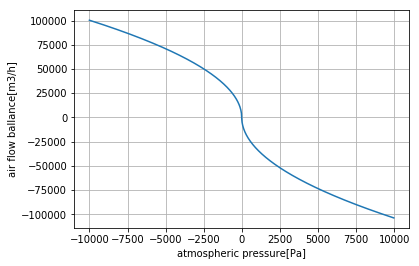

In [21]:
# 収束用関数の連続性の確認(bisectの初期値の検討)

# /検討パラメータ
val_min = -1 * 10**4
val_max = 10**4
# 検討パラメータ/

room_temperature = 20 
outside_air_temperature = 0
total_leakage_area_of_house_per_unit_area = 2.0
total_floor_area = 120
use_chimney= False
opening_area_of_supply_air = 0.1
opening_area_of_exhaust_air = 0.1
house_story_number = 2

x = np.zeros(1000)
y = np.zeros(1000)

stp = (val_max - val_min) / 1000
    
for t in range(1000):
    
    x[t] = val_min + stp * t
    
    atmospheric_pressure_at_a_basic_height = x[t]
    
    a1, a2, a3 = air_flow(
                    atmospheric_pressure_at_a_basic_height,
                    room_temperature,
                    outside_air_temperature,
                    total_leakage_area_of_house_per_unit_area,
                    total_floor_area,
                    use_chimney,
                    opening_area_of_supply_air,
                    opening_area_of_exhaust_air,
                    house_story_number)
    
    y[t] = a1
    # print (t, x[t], y[t])
    
    
# plt.figure(figsize=(9,2))
# plt.subplot(1,1,1)
plt.plot(x, y)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("atmospheric pressure[Pa]")
plt.ylabel("air flow ballance[m3/h]")

# plt.xlim(3.9,4)
# plt.ylim(-1,1)

plt.legend()
plt.show()




In [22]:
# すきま風マクロ.xlsmの結果と一致するか確認（繰り返し計算あり）

room_air_temperature = 20 # ℃
outside_air_temperature = 0 # ℃
c_value = 2  # cm^2/m^2
total_floor_area = 120 # m^2
use_chimney = False
opening_area_of_supply_air = 0.1 # m^2
opening_area_of_exhaust_air = 0.1 # m^2
house_story_number = 2 # 階

natural_ventilation_volume(
        room_temperature,
        outside_air_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number)


565.52490421596906

# テスト

## ハイブリッド換気

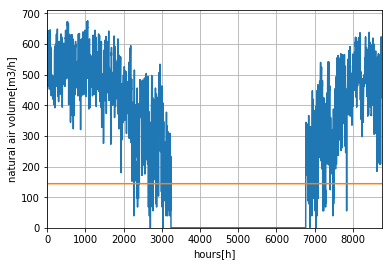

In [23]:
# 温度差利用ハイブリッド換気の自然換気量の確認

area_number = 5 # 地域区分

hourly_outside_air_temperature = import_outside_air_temperature_d_t(area_number)
daily_heating_season = import_heating_season_d(area_number)

room_temperature = 20 # ℃
total_leakage_area_of_house_per_unit_area = 2 # cm^2/m^2
total_floor_area = 120 # m^2 
use_chimney = False
opening_area_of_supply_air = 0.1 # m^2
opening_area_of_exhaust_air = 0.1 # m^2
house_story_number = 2 # 階


x = np.arange(8760)
y =hourly_natural_ventilation_volume(
        hourly_outside_air_temperature,
        daily_heating_season,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_air,
        opening_area_of_exhaust_air,
        house_story_number)

# 機械換気風量
v = np.ones(8760)
v = v * total_floor_area * 2.4 * 0.5

plt.plot(x, y)
plt.plot(x, v)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("hours[h]")
plt.ylabel("natural air volume[m3/h]")

plt.xlim(0, 8760)
plt.ylim(0,)

plt.legend()
plt.show()


## 全体テスト

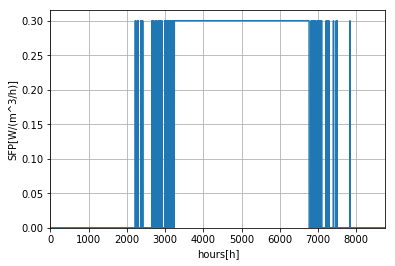

In [24]:
# 全体での動作確認

ventilation_control_mode = "温度差利用型ハイブリッド運転"
# "制御しない" "片側運転" "バイパス運転" "温度差利用型ハイブリッド運転"
sfp = 0.3
sfp_bypass = 0.2
area_number = 5 # 地域区分
mechanical_ventilation_volume = 158.5 # m^3/h
room_temperature = 20 # ℃
total_leakage_area_of_house_per_unit_area = 2 # cm^2/m^2
total_floor_area = 120 # m^2 
use_chimney = False
opening_area_of_supply_and_exhaust_air = 0.2 # m^2
house_story_number = 2 # 階

x = np.arange(8760)
y = hourly_sfp(
        ventilation_control_mode,
        sfp,
        sfp_bypass,
        area_number,
        mechanical_ventilation_volume,
        room_temperature,
        total_leakage_area_of_house_per_unit_area,
        total_floor_area,
        use_chimney,
        opening_area_of_supply_and_exhaust_air,
        house_story_number)

'''
# 通常のSFP
v = np.ones(8760)
v = v * sfp
'''

plt.plot(x, y)
#plt.plot(x, v)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("hours[h]")
plt.ylabel("SFP[W/(m^3/h)]")

plt.xlim(0, 8760)
plt.ylim(0,)

plt.legend()
plt.show()
